In [2]:
from xai.genome import Genome
from xai.bytes import GigaBytes
from xai.policy import Policy
from xai.asteroids import Asteroids
import matplotlib.pyplot as plt
import torch

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
genome = Genome(translate=True, rotate=True)

population = genome.populate(
    population_size=25,
    max_memory=GigaBytes(5.0),
    verbose=True
)

Disk used: 0.65/5.00GB: : 25it [00:05,  4.85it/s]


In [6]:
population.evolve(
    generations=10,
    survivors_cnt=1,
    elites_cnt=0,
    roulettes_cnt=0,
    random_cnt=0,
    rank_cnt=10,
    checkpoints_directory="Test",
    number_of_processes=4
)

Generation: 0/10: 100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


Worst: {'rewards': {'NONE': 0.0, 'BIG_ASTEROID': 100.0, 'MEDIUM_ASTEROID': 150.0, 'SMALL_ASTEROID': 100.0}, 'penalties': {}}
Best: {'rewards': {'NONE': 0.0, 'BIG_ASTEROID': 380.0, 'MEDIUM_ASTEROID': 1750.0, 'SMALL_ASTEROID': 2700.0}, 'penalties': {}}


Disk used: 0.34/5.00GB: : 13it [00:03,  3.65it/s]


KeyboardInterrupt: 

In [7]:
population._observations

Buffer(use_ram=False, entries=13396, size=2705.71MB, capacity=27.06%)

In [19]:
torch.cuda.empty_cache()

In [20]:
hidden_dims = [2**8,2**7]
big_encoder = Policy.new(Asteroids.observation_shape, 100, hidden_layers=hidden_dims)
big_decoder = Policy.new(100, Asteroids.observation_shape ,hidden_layers=hidden_dims[::-1])
big_autoencoder = big_encoder + big_decoder
big_autoencoder

Sequential(
  (0): Linear(in_features=100800, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=100, bias=True)
  (5): Linear(in_features=100, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=100800, bias=True)
)

In [21]:
tensor = torch.stack(population._observations.randoms(False).take(1000).map(lambda obs: obs.translated().rotated().tensor(True, "cuda:0")).tuple())


In [14]:
del tensor

NameError: name 'tensor' is not defined

In [22]:
big_autoencoder.adam().fit(
    X=tensor,
    Y=tensor,
    epochs=5000,
    batch_size=64,
    loss_criterion="MSELoss",
    verbose=True
).plot_loss()

Step::   0%|          | 0/5000 [00:00<?, ?it/s]

Loss: 0.013008:   0%|          | 20/5000 [00:17<1:14:14,  1.12it/s]


KeyboardInterrupt: 

In [14]:
big_autoencoder.predict(tensor[0]).tensor(True).cpu().max()

tensor(0.7805)

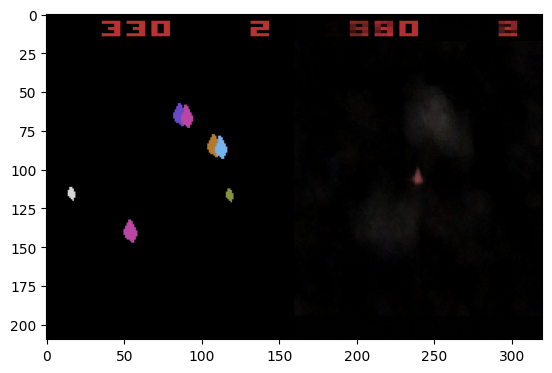

In [20]:

idx = 2198



plt.imshow(torch.hstack([tensor[idx].cpu(), big_autoencoder.predict(tensor[idx]).tensor(True).cpu()]))